In [31]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim import corpora, models, similarities, matutils

import nltk
from nltk.corpus import stopwords

from pprint import pprint

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer


In [40]:
#Samaras Laptop
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')
#song_data = song_data[(song_data['Language'] == 'en')]
#song_data.to_csv("outData.csv", index=False)
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')


#Anjas Laptop
# song_data = pd.read_csv('../Daten/train.csv')
# song_data = song_data[(song_data['Language'] == 'en')]
# song_data.to_csv("../Daten/outData.csv", index=False)
song_data = pd.read_csv('../Daten/outData.csv')

## Get a balanced sample of 5 songs per genre

In [41]:
num_genres = song_data.Genre.nunique()
num_topics = num_genres

In [42]:
song_data = song_data[["Genre", "Lyrics"]]
song_data = song_data.groupby('Genre').sample(200).reset_index(drop=True)
song_data.head(10)

,Genre,Lyrics
0,Country,"Look out boys, 'cause I'm a rollin' stone That..."
1,Country,Baby hear me callin' baby Come over here and l...
2,Country,Nice to meet you what's your name where ya fro...
3,Country,"Well, I've seen that look a thousand times And..."
4,Country,I just might take to leavin' in the middle of ...
5,Country,"For my girls The fighters, the warriors Broken..."
6,Country,I'd sing the Red River Valley And he'd sit in ...
7,Country,"She said so, so many times in my life Once I t..."
8,Country,Workin' hard all my life Always tried to get i...
9,Country,Someday when I'm old I'll pull up to the store...


## Remove punctuation/lower casing

In [43]:
song_data_processed = song_data.copy()
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].map(lambda x: x.lower())

## Remove stopwords and Tokenize

In [44]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
stop_words = stopwords.words('english')
new_stop_words = ['ooh','oh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa', 'intro', 'chorus', 'bridge', 'refrain']
stop_words.extend(new_stop_words)

max_df: je niedriger dieser Wert, desto mehr Mainstream wörter, die in allen songs vorkommen, werden nicht beachtet

In [46]:
#Turn Lyrics into vectorized form (based on counts)
count_vec = CountVectorizer(stop_words=stop_words, max_df=0.2, min_df=0.01, ngram_range=(1,1))
words_df = count_vec.fit_transform(song_data_processed.Lyrics)

In [47]:
words_df = words_df.transpose()
corpus = matutils.Sparse2Corpus(words_df)
id2word = dict((v, k) for k, v in count_vec.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=100, random_state=11)

In [48]:
lda.print_topics(num_words=10)

[(0,
  '0.013*"us" + 0.013*"world" + 0.011*"night" + 0.009*"god" + 0.009*"sky" + 0.009*"eyes" + 0.009*"new" + 0.008*"light" + 0.008*"war" + 0.008*"blue"'),
 (1,
  '0.025*"away" + 0.021*"alone" + 0.019*"would" + 0.017*"find" + 0.014*"home" + 0.013*"eyes" + 0.013*"nothing" + 0.012*"inside" + 0.012*"left" + 0.012*"leave"'),
 (2,
  '0.108*"baby" + 0.054*"wanna" + 0.052*"girl" + 0.034*"gonna" + 0.031*"night" + 0.024*"tell" + 0.021*"need" + 0.013*"give" + 0.013*"turn" + 0.010*"nice"'),
 (3,
  '0.020*"long" + 0.018*"every" + 0.017*"much" + 0.016*"tell" + 0.014*"ever" + 0.014*"always" + 0.013*"everything" + 0.013*"give" + 0.012*"still" + 0.011*"keep"'),
 (4,
  '0.034*"man" + 0.030*"la" + 0.027*"little" + 0.017*"old" + 0.016*"well" + 0.013*"girl" + 0.013*"good" + 0.011*"said" + 0.011*"great" + 0.010*"night"'),
 (5,
  '0.054*"ready" + 0.042*"uh" + 0.036*"hand" + 0.036*"ah" + 0.030*"man" + 0.026*"huh" + 0.025*"da" + 0.025*"rock" + 0.020*"yes" + 0.018*"show"'),
 (6,
  '0.032*"better" + 0.021*"comi

### Finding umbrella Terms for the Topics
0 - Global Reflections  
1 - Solitude and Searching  
2 - Romantic Desires  
3 - Timeless Sentiments  
4 - Character Sketches  
5 - Performance and Engagement  
6 - Self-Improvement and Ambition  
7 - Social Connections and Experience  
8 - Life's Journeys and Reflections  
9 - Urban Culture and Expression  

### Auswertung Topics

In [49]:
docTopicProbMat = lda[corpus]
csr = matutils.corpus2csc(docTopicProbMat)
doc_top = csr.T.toarray()
doc_top_df = pd.DataFrame(doc_top, columns = [i for i in range(0, num_topics)])
results = pd.merge(song_data_processed, doc_top_df, left_index=True, right_index=True)
results['Dominant_Topic'] = results[[i for i in range(0, num_topics)]].idxmax(axis=1)
results

,Genre,Lyrics,0,1,2,3,4,5,6,7,8,9,Dominant_Topic
0,Country,look out boys 'cause i'm a rollin' stone that'...,0.000000,0.060304,0.000000,0.090583,0.745987,0.000000,0.000000,0.000000,0.093598,0.000000,4
1,Country,baby hear me callin' baby come over here and l...,0.000000,0.000000,0.592668,0.000000,0.087612,0.000000,0.000000,0.000000,0.303047,0.000000,2
2,Country,nice to meet you what's your name where ya fro...,0.000000,0.000000,0.178754,0.502799,0.141369,0.037721,0.000000,0.026568,0.000000,0.109118,3
3,Country,well i've seen that look a thousand times and ...,0.000000,0.599880,0.076885,0.000000,0.000000,0.000000,0.124998,0.109162,0.083518,0.000000,1
4,Country,i just might take to leavin' in the middle of ...,0.000000,0.071522,0.041941,0.661607,0.000000,0.000000,0.000000,0.216818,0.000000,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Rock,hark how the bells\nsweet silver bells\nall se...,0.734779,0.000000,0.051940,0.000000,0.000000,0.000000,0.000000,0.199551,0.000000,0.000000,0
1996,Rock,look out somebody's comin'\nhe's got the key t...,0.000000,0.000000,0.000000,0.373849,0.000000,0.000000,0.178110,0.000000,0.083735,0.344945,3
1997,Rock,duet with george michael\nmusic by elton john\...,0.000000,0.000000,0.569155,0.000000,0.400057,0.000000,0.000000,0.000000,0.000000,0.000000,2
1998,Rock,you've filled this house with things of gold\n...,0.086221,0.255802,0.000000,0.241015,0.110045,0.027863,0.000000,0.000000,0.169749,0.105853,1


### Explore Results

#### Crosstab

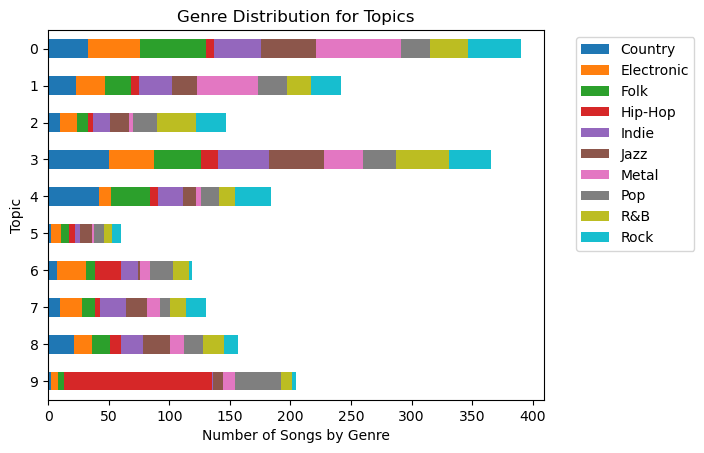

In [50]:
# Create a crosstab
crosstab = pd.crosstab(results['Dominant_Topic'], results['Genre']).sort_values(by="Dominant_Topic", ascending=False)

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Topic')
plt.title('Genre Distribution for Topics')
plt.show()

#### Visualization (PCA) (visualizing LDA Results)

In [51]:
results

,Genre,Lyrics,0,1,2,3,4,5,6,7,8,9,Dominant_Topic
0,Country,look out boys 'cause i'm a rollin' stone that'...,0.000000,0.060304,0.000000,0.090583,0.745987,0.000000,0.000000,0.000000,0.093598,0.000000,4
1,Country,baby hear me callin' baby come over here and l...,0.000000,0.000000,0.592668,0.000000,0.087612,0.000000,0.000000,0.000000,0.303047,0.000000,2
2,Country,nice to meet you what's your name where ya fro...,0.000000,0.000000,0.178754,0.502799,0.141369,0.037721,0.000000,0.026568,0.000000,0.109118,3
3,Country,well i've seen that look a thousand times and ...,0.000000,0.599880,0.076885,0.000000,0.000000,0.000000,0.124998,0.109162,0.083518,0.000000,1
4,Country,i just might take to leavin' in the middle of ...,0.000000,0.071522,0.041941,0.661607,0.000000,0.000000,0.000000,0.216818,0.000000,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Rock,hark how the bells\nsweet silver bells\nall se...,0.734779,0.000000,0.051940,0.000000,0.000000,0.000000,0.000000,0.199551,0.000000,0.000000,0
1996,Rock,look out somebody's comin'\nhe's got the key t...,0.000000,0.000000,0.000000,0.373849,0.000000,0.000000,0.178110,0.000000,0.083735,0.344945,3
1997,Rock,duet with george michael\nmusic by elton john\...,0.000000,0.000000,0.569155,0.000000,0.400057,0.000000,0.000000,0.000000,0.000000,0.000000,2
1998,Rock,you've filled this house with things of gold\n...,0.086221,0.255802,0.000000,0.241015,0.110045,0.027863,0.000000,0.000000,0.169749,0.105853,1


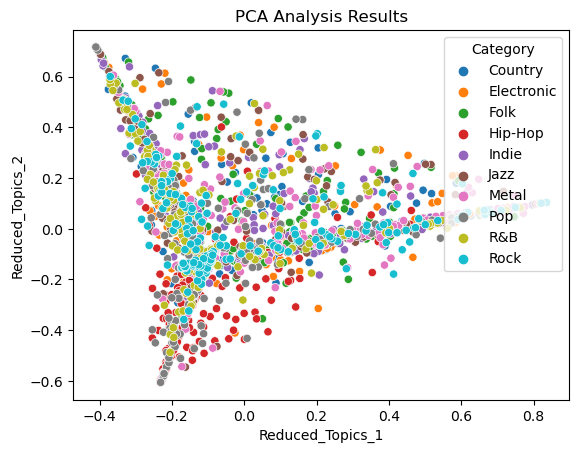

In [52]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(results[[i for i in range(0, num_topics)]])
results[['Reduced_Topics_1', 'Reduced_Topics_2']] = reduced
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Using Clustering

In [53]:
kmeans = KMeans(n_clusters=num_genres, random_state=0).fit(results[[i for i in range(0, num_topics)]])
results["Cluster"] = kmeans.labels_
results

c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Genre,Lyrics,0,1,2,3,4,5,6,7,8,9,Dominant_Topic,Reduced_Topics_1,Reduced_Topics_2,Cluster
0,Country,look out boys 'cause i'm a rollin' stone that'...,0.000000,0.060304,0.000000,0.090583,0.745987,0.000000,0.000000,0.000000,0.093598,0.000000,4,-0.124703,-0.034374,0
1,Country,baby hear me callin' baby come over here and l...,0.000000,0.000000,0.592668,0.000000,0.087612,0.000000,0.000000,0.000000,0.303047,0.000000,2,-0.148443,-0.151458,5
2,Country,nice to meet you what's your name where ya fro...,0.000000,0.000000,0.178754,0.502799,0.141369,0.037721,0.000000,0.026568,0.000000,0.109118,3,-0.284739,0.245902,3
3,Country,well i've seen that look a thousand times and ...,0.000000,0.599880,0.076885,0.000000,0.000000,0.000000,0.124998,0.109162,0.083518,0.000000,1,-0.092156,-0.104021,4
4,Country,i just might take to leavin' in the middle of ...,0.000000,0.071522,0.041941,0.661607,0.000000,0.000000,0.000000,0.216818,0.000000,0.000000,3,-0.308990,0.434787,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Rock,hark how the bells\nsweet silver bells\nall se...,0.734779,0.000000,0.051940,0.000000,0.000000,0.000000,0.000000,0.199551,0.000000,0.000000,0,0.591424,0.037390,8
1996,Rock,look out somebody's comin'\nhe's got the key t...,0.000000,0.000000,0.000000,0.373849,0.000000,0.000000,0.178110,0.000000,0.083735,0.344945,3,-0.266929,0.010345,3
1997,Rock,duet with george michael\nmusic by elton john\...,0.000000,0.000000,0.569155,0.000000,0.400057,0.000000,0.000000,0.000000,0.000000,0.000000,2,-0.139652,-0.133812,5
1998,Rock,you've filled this house with things of gold\n...,0.086221,0.255802,0.000000,0.241015,0.110045,0.027863,0.000000,0.000000,0.169749,0.105853,1,-0.102730,0.060896,4


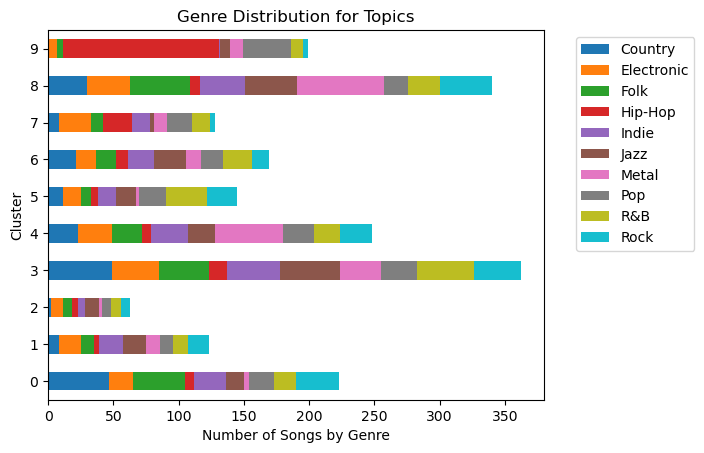

In [54]:
# Create a crosstab
crosstab = pd.crosstab(results['Cluster'], results['Genre'])

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Cluster')
plt.title('Genre Distribution for Topics')
plt.show()

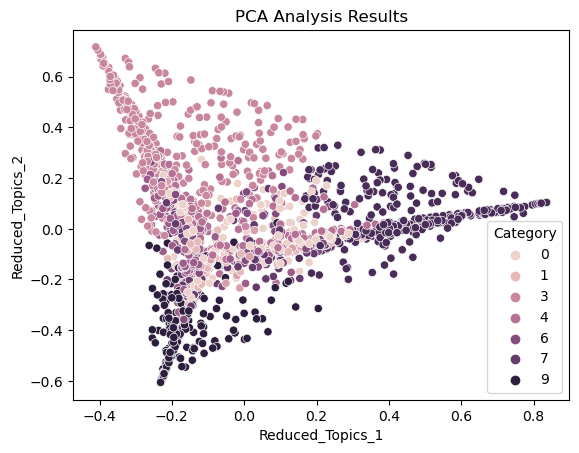

In [55]:
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Cluster', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Trying to predict the genre based on the topic vector

In [56]:
X = results[[i for i in range(0, num_topics)]]
label_encoder = LabelEncoder()
results["GenreID"] = label_encoder.fit_transform(results["Genre"])
y = results["GenreID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [57]:
#K-nearest neighbors
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.19166666666666668

In [58]:
#svm classifier
svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.22

In [59]:
#Random forest
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.19166666666666668

### Get Classification Matrix (of knn)

In [63]:
y_pred = svc.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.16      0.29      0.21        52
           1       0.12      0.04      0.06        69
           2       0.12      0.01      0.02        72
           3       0.49      0.65      0.56        55
           4       0.20      0.13      0.16        54
           5       0.15      0.53      0.24        49
           6       0.23      0.54      0.32        57
           7       0.00      0.00      0.00        62
           8       0.23      0.19      0.21        64
           9       0.20      0.02      0.03        66

    accuracy                           0.22       600
   macro avg       0.19      0.24      0.18       600
weighted avg       0.19      0.22      0.17       600



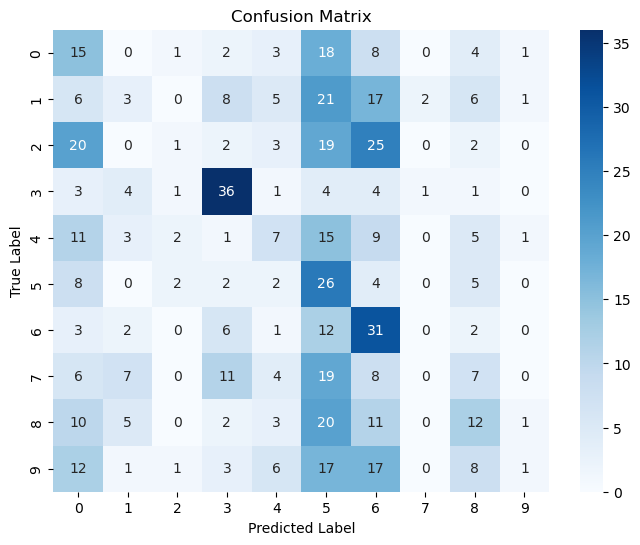

In [64]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the class labels
class_labels = svc.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [62]:
results[["Genre", "GenreID"]].drop_duplicates()

,Genre,GenreID
0,Country,0
200,Electronic,1
400,Folk,2
600,Hip-Hop,3
800,Indie,4
1000,Jazz,5
1200,Metal,6
1400,Pop,7
1600,R&B,8
1800,Rock,9


### Was hier gemacht wurde:
- Nehmen eines song subsets mit jeweils n songs aus jedem der m genres
- Bereinigen der Lyrics mit verschiedenen Preprocessing methoden (Best Practice)
- Using LDA to get most important topic based on all the songs
- applying the LDA topics to each song individually
- Investigating whether there is a correlation between the topics and the song genres, using crosstabs and, PCA-Scatterplots and Clustering
- Investigating whether it is possible to predict a genre based on its most prominent topics 

### Ergebnis
- Teils Zusammenhang zwischen prominenten Topics und Song Genres
- Vor Allem HipHop Topics fallen auffallend oft in die gleiche Kategorie
- Ergebnisse eindeutiger als bei der Vorherigen Lösung
- Vorhersage des Genres aus Topics nach wie vor nur schlecht möglich
- Einige Genres wie Folk und Pop sind extrem schwer vorherzusagen, was wohl bedeutet dass hier die Themenbereiche am wenigsten eingeschränkt sind
- Auf dem zweiten Platz ist Metall, was auch relativ gut vorhergesagt wird

### Interpretation
- Das Model funktioniert bereits besser als das vorherige. Die Vermutung liegt nahe, dass es zwischen manchen Genres mehr Unterschiede als zwischen anderen gibt. Ein gutes beispiel dafür ist HipHop, das sich relativ klar unterscheiden lässt.